In [ ]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.7 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
from diffusers import UNet2DModel
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, Softplus
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
import tqdm.notebook as tqdm

DEVICE = 'cuda'

unet = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32,64,128),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
        "UpBlock2D",  # a regular ResNet upsampling block
    )
)

unet.to(DEVICE)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D

In [ ]:
from tqdm.notebook import tqdm
from time import sleep

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
transforms.ToTensor(), transforms.Lambda(lambda x: ((x - x.min())/(x.max() - x.min()))*254 + 1)])
                                 #transforms.Normalize(mean=0.5, std=0.5)])

BATCH_SIZE = 256

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False)
# classes = ('plane', 'car', 'bird', 'cat',
          #  'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The neural network has {count_parameters(unet):,} trainable parameters")
image = next(iter(trainloader))[0].to(DEVICE)
with torch.no_grad():

  print(unet(image, torch.rand(image.shape[0],device=DEVICE)).sample.shape)

The neural network has 3,939,393 trainable parameters
torch.Size([256, 1, 28, 28])


In [ ]:
def poisson_divergence(lambd1, lambd2):
  """
    Takes in two vector of poissons and computes the sum of the KL divergences element-wise
    The lambda vectors may be 2 dimensional as is the case for images.
  """

  assert(torch.is_tensor(lambd1))
  assert(torch.is_tensor(lambd2))

  elementwise_div = (lambd1*(torch.log(lambd1) - torch.log(lambd2)) + lambd2 - lambd1)
  return elementwise_div.sum()


def loss(f, alpha_ti, alpha_tim1, ti, x0, zti, initial_rate = torch.tensor(10.0, device=DEVICE)):
  """
    Computes the Poisson at a particular time.
    f : nn.Module representing the neural network (The neural net is a map from B x D to B x D ... Something like UNet)
    alpha_ti: schedule at time t_{i}
    alpha_tim1: Schedule at time t_{i-1} --> The schedule is decreasing as time increases.
    x0 : B x D batch of datapoints.
  """

  delta_alpha = alpha_tim1 - alpha_ti
  x0hat = f(zti, ti)
  arg1 = initial_rate*x0*delta_alpha
  arg2 = initial_rate*x0hat*delta_alpha
  # print(x0.min(), delta_alpha.min())
  # print(arg1.min(), arg2.min())

  assert(arg1.min() > 0)
  assert(arg2.min() > 0)

  return poisson_divergence(arg1, arg2)



def alpha_schedule(t, device=DEVICE):
  if not torch.is_tensor(t):
    t = torch.tensor(t, device=DEVICE)
  return torch.sigmoid(10 + (-13 - 10)*t)






In [ ]:
EPOCHS = 100
INITIAL_RATE = torch.tensor(10.0, device=DEVICE)
optim = Adam(unet.parameters(), lr=3e-4)
for epoch in tqdm(range(EPOCHS)):
  for x, _ in iter(trainloader):
    x = x.to(DEVICE)
    optim.zero_grad()
    t = torch.rand((x.shape[0]), device=DEVICE)
    alpha_t = alpha_schedule(t).view(-1,1,1,1).to(DEVICE)
    Zt = torch.distributions.Poisson(INITIAL_RATE*alpha_t*x).sample().to(DEVICE)
    xhat = Softplus()(unet(Zt,t).sample)
    objective = poisson_divergence(x, xhat)
    objective.backward()
    optim.step()
    print(f"loss {objective.item()}")

  0%|          | 0/100 [00:00<?, ?it/s]

loss 8188247.0
loss 7910170.0
loss 7858306.0
loss 7964882.0
loss 7405623.5
loss 7612736.0
loss 7386095.0
loss 6894157.0
loss 7786577.5
loss 7472553.0
loss 7464056.0
loss 7410630.0
loss 7545209.0
loss 6896876.0
loss 7430435.5
loss 7308859.0
loss 7429179.5
loss 7331912.0
loss 7391014.0
loss 7523337.0
loss 7541238.0
loss 7251963.0
loss 7370564.5
loss 7202661.0
loss 7072774.5
loss 7288163.0
loss 7081744.0
loss 6999867.0
loss 7317327.0
loss 7105705.0
loss 7003920.0
loss 6915321.5
loss 7230999.0
loss 7072312.0
loss 7611292.0
loss 7114769.0
loss 7006231.0
loss 7089044.0
loss 6858189.0
loss 6885526.0
loss 6786186.0
loss 6653989.0
loss 6542451.0
loss 6841363.0
loss 6559886.0
loss 6774988.0
loss 7002405.5
loss 6651486.5
loss 6633191.0
loss 6799048.0
loss 6943494.0
loss 6781404.5
loss 6488861.5
loss 6610906.5
loss 6536484.0
loss 6738450.0
loss 6322478.0
loss 6414792.5
loss 6432991.0
loss 6740306.5
loss 6653329.0
loss 6247972.0
loss 7081234.0
loss 6525102.0
loss 6617045.0
loss 6218931.0
loss 63401

KeyboardInterrupt: ignored

In [ ]:
z = torch.zeros((25,1,28,28)).to(DEVICE)
initial_rate = torch.tensor(10.0, device = DEVICE)
with  torch.no_grad():
  T = torch.linspace(0, 1, 100)
  for idx, t in enumerate(reversed(T[1:])):

    xhat = Softplus()(unet(z, torch.tensor(t, device=DEVICE)).sample)
    alpha_ti = alpha_schedule(torch.tensor(t,device=DEVICE))
    alpha_tim1 = alpha_schedule(torch.tensor(T.clone().detach().cpu()[-idx-2], device = DEVICE))
    z = z + torch.distributions.Poisson(initial_rate*(alpha_tim1 - alpha_ti)*xhat).sample()
  z = z/initial_rate

# import matplotlib.pyplot as plt
# plt.imshow(z.squeeze(0).squeeze(0).cpu().detach().numpy())

<ipython-input-119-64d5cc24cba8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xhat = Softplus()(unet(z, torch.tensor(t, device=DEVICE)).sample)
<ipython-input-119-64d5cc24cba8>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_ti = alpha_schedule(torch.tensor(t,device=DEVICE))
<ipython-input-119-64d5cc24cba8>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_tim1 = alpha_schedule(torch.tensor(T.clone().detach().cpu()[-idx-2], device = DEVICE))


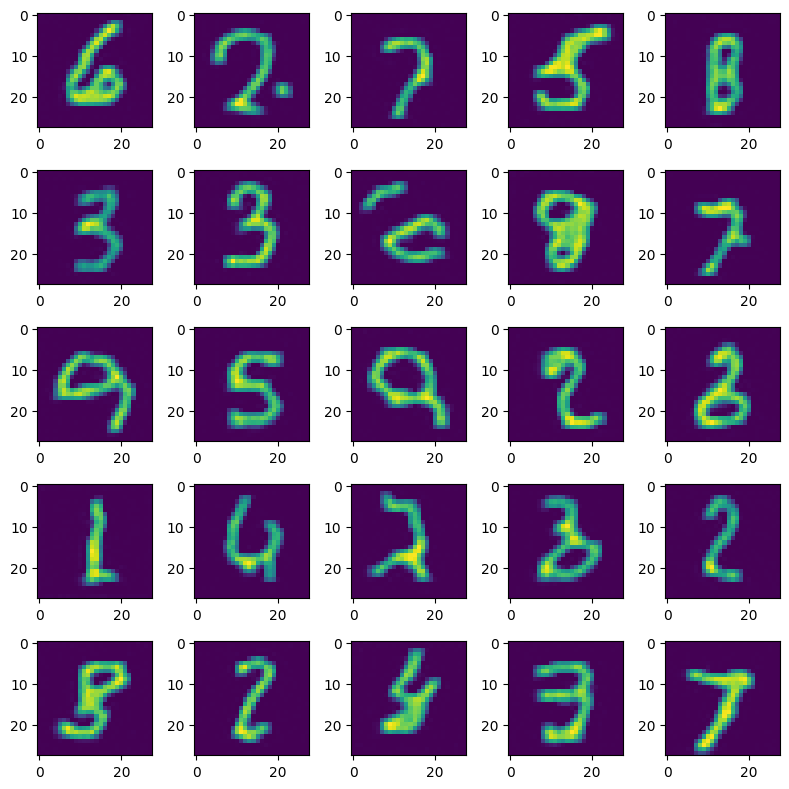

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(z[i].detach().cpu().numpy()[0])#, cmap='Greys')
fig.tight_layout()